In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Step 2: PCA / POD

In [2]:
import numpy as np
from numpy import linalg as LA
import pyfftw
import matplotlib.pyplot as plt

In [3]:
###############################################################################
#POD Routines
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]  
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u

In [4]:
def fpsi(nx, ny, dx, dy, f):
    epsilon = 1.0e-6
    aa = -2.0/(dx*dx) - 2.0/(dy*dy)
    bb = 2.0/(dx*dx)
    cc = 2.0/(dy*dy)
    hx = 2.0*np.pi/np.float64(nx)
    hy = 2.0*np.pi/np.float64(ny)
    
    kx = np.empty(nx)
    ky = np.empty(ny)
    
    kx[:] = hx*np.float64(np.arange(0, nx))

    ky[:] = hy*np.float64(np.arange(0, ny))
    
    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(np.cos(kx), np.cos(ky), indexing='ij')
    
    data = np.empty((nx,ny), dtype='complex128')
    data1 = np.empty((nx,ny), dtype='complex128')
    
    data[:,:] = np.vectorize(complex)(f,0.0)

    a = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    b = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    
    fft_object = pyfftw.FFTW(a, b, axes = (0,1), direction = 'FFTW_FORWARD')
    fft_object_inv = pyfftw.FFTW(a, b,axes = (0,1), direction = 'FFTW_BACKWARD')
    
    e = fft_object(data)
    #e = pyfftw.interfaces.scipy_fftpack.fft2(data)
    
    e[0,0] = 0.0
    
    data1[:,:] = e[:,:]/(aa + bb*kx[:,:] + cc*ky[:,:])

    ut = np.real(fft_object_inv(data1))
        
    return ut

In [5]:
#%% Main program:
# Inputs
nx =  256   #spatial grid number
ny = 256    #spatial grid number
nc = 4      #number of control parameters (nu)
ns = 200    #number of snapshot per each Parameter 
nr = 8      #number of modes
Re_start = 200.0 #Lower range of Reynods number
Re_final = 800.0 #Upper range of Reynolds number
Re  = np.linspace(Re_start, Re_final, nc) #control Reynolds
nu = 1/Re   #control dissipation
lx = 2.0*np.pi
ly = 2.0*np.pi
dx = lx/nx
dy = ly/ny
dt = 1e-1
tm = 20.0
ReTest = 500
training = 'true'

In [6]:
#%% Data generation for training
x = np.linspace(0, lx, nx+1)
y = np.linspace(0, ly, ny+1)
t = np.linspace(0, tm, ns+1)

um = np.zeros(((nx)*(ny), ns+1, nc))
up = np.zeros(((nx)*(ny), ns+1, nc))
uo = np.zeros(((nx)*(ny), ns+1, nc))

for p in range(0,nc):
    for n in range(0,ns+1):
        file_input = "./snapshots/Re_"+str(int(Re[p]))+"/w/w_"+str(int(n))+ ".csv"
        w = np.genfromtxt(file_input, delimiter=',')
        
        w1 = w[1:nx+1,1:ny+1]
        
        um[:,n,p] = np.reshape(w1,(nx)*(ny)) #snapshots from unperturbed solution
        uo[:,n,p] = um[:,n,p] 

In [7]:
#%% POD basis computation
PHIw = np.zeros(((nx)*(ny),nr,nc))
PHIs = np.zeros(((nx)*(ny),nr,nc))        
       
L = np.zeros((ns+1,nc)) #Eigenvalues      
RIC = np.zeros((nc))    #Relative information content

print('Computing POD basis for vorticity ...')
for p in range(0,nc):
    u = uo[:,:,p]
    PHIw[:,:,p], L[:,p], RIC[p]  = POD(u, nr) 

PHIw = PHIw/(np.sign(PHIw[0,:,:]))

Computing POD basis for vorticity ...


In [8]:
#%%    
print('Computing POD basis for streamfunction ...')
for p in range(0,nc):
    for i in range(nr):
        phi_w = np.reshape(PHIw[:,i,p],[nx,ny])
        phi_s = fpsi(nx, ny, dx, dy, -phi_w)
        PHIs[:,i,p] = np.reshape(phi_s,(nx)*(ny))

Computing POD basis for streamfunction ...


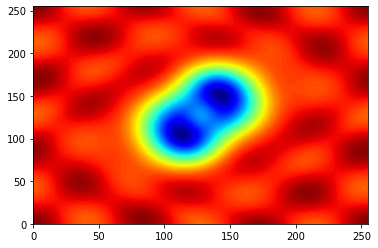

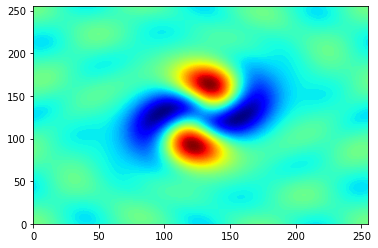

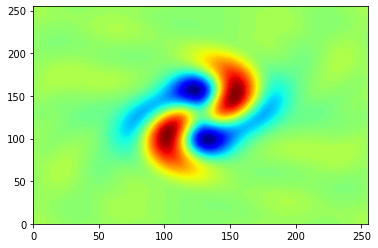

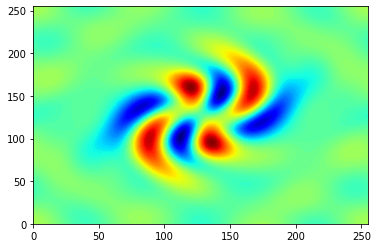

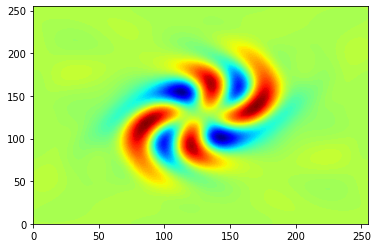

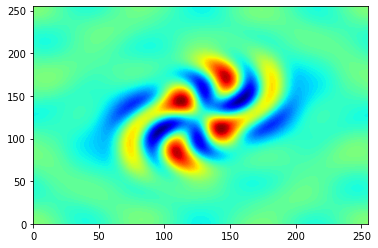

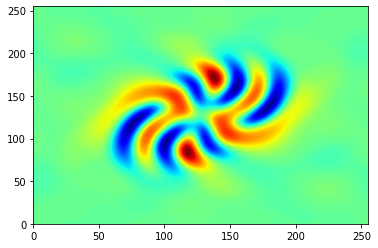

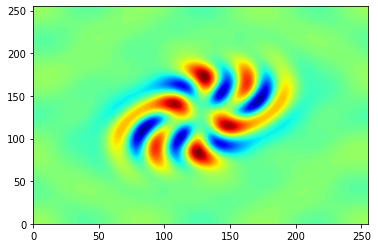

In [9]:
Phi=PHIw.reshape(nx,ny,8,4)
for i in range(0,8):
    plt.contourf(Phi[:,:,i,0],120, cmap = 'jet')
    plt.savefig("./Phi_" + str(int(i))+".png", bbox_inches = 'tight')
    plt.show()

# Reference
https://arxiv.org/pdf/1910.13909.pdf